In [49]:
"""Plot frequency comb from NLTL simulation using PyQSPICE."""
import numpy as np
import matplotlib.pyplot as plt
from PyQSPICE import clsQSPICE as pqs
from pathlib import Path
import shutil

In [50]:
# Setup PyQSPICE
work_dir = Path(r"c:\Users\madan\Documents\QSPICE\QSPICE_DSP\dauffing")
qsch_file = work_dir / "dauffing.qsch"


In [51]:
run = pqs(str(work_dir / "dauffing"))


In [52]:
# Load the qraw data — PyQSPICE needs the qraw to exist already
# It uses QUX.exe -Export to read it
probes = ["V(x1)", "V(x2)", "V(x3)", "V(x4)", "V(x5)", "V(x6)", "V(x7)", "V(x8)"]
df = run.LoadQRAW(probes)

print(f"Loaded DataFrame: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(df.head())

Loaded DataFrame: (5000, 10)
Columns: ['Time', 'V(x1)', 'V(x2)', 'V(x3)', 'V(x4)', 'V(x5)', 'V(x6)', 'V(x7)', 'V(x8)', 'Step']
     Time         V(x1)         V(x2)         V(x3)         V(x4)  \
0  0.0000  8.053193e-08  6.902584e-08  5.752045e-08  4.601565e-08   
1  1.0002  1.188340e-01  9.730456e-03  5.680758e-04  2.898322e-05   
2  2.0004  5.144547e-01  1.280292e-01  2.043482e-02  2.720358e-03   
3  3.0006  9.620522e-01  4.531581e-01  1.427837e-01  3.622145e-02   
4  4.0008  1.316906e+00  8.703517e-01  4.330493e-01  1.700677e-01   

          V(x5)         V(x6)         V(x7)         V(x8)  Step  
0  3.451133e-08  2.300736e-08  1.150362e-08  1.123419e-15     0  
1  1.425511e-06  8.817914e-08  1.496337e-08  4.045665e-09     0  
2  3.487246e-04  4.618721e-05  6.459390e-06  8.043363e-07     0  
3  8.464339e-03  1.959170e-03  4.603516e-04  9.523726e-05     0  
4  5.737612e-02  1.767569e-02  5.110168e-03  1.228757e-03     0  


In [53]:

time = df['Time'].values
vx8 = df['V(x8)'].values

print(f"\nTime: {time[0]:.1f} to {time[-1]:.1f} s ({len(time)} points)")
print(f"V(x8): {vx8.min():.2f} to {vx8.max():.2f} V")

# Use steady-state portion (last 50%)
t_start = time[-1] * 0.5
mask = time >= t_start
t_ss = time[mask]
v_ss = vx8[mask]
print(f"Steady-state: {t_ss[0]:.0f}s to {t_ss[-1]:.0f}s ({len(t_ss)} points)")


Time: 0.0 to 5000.0 s (5000 points)
V(x8): -2.36 to 2.23 V
Steady-state: 2501s to 5000s (2500 points)


In [54]:
# Resample to uniform grid for FFT
N_resample = 16384
t_uniform = np.linspace(t_ss[0], t_ss[-1], N_resample)
v_uniform = np.interp(t_uniform, t_ss, v_ss)
dt = t_uniform[1] - t_uniform[0]
print(f"Resampled: {N_resample} points, dt={dt:.4f}s, fs={1/dt:.2f} Hz")

# Window and FFT
window = np.hanning(N_resample)
v_windowed = (v_uniform - np.mean(v_uniform)) * window
fft_vals = np.fft.rfft(v_windowed)
freqs = np.fft.rfftfreq(N_resample, d=dt)
magnitude_dB = 20 * np.log10(np.abs(fft_vals) / N_resample + 1e-15)

Resampled: 16384 points, dt=0.1526s, fs=6.55 Hz


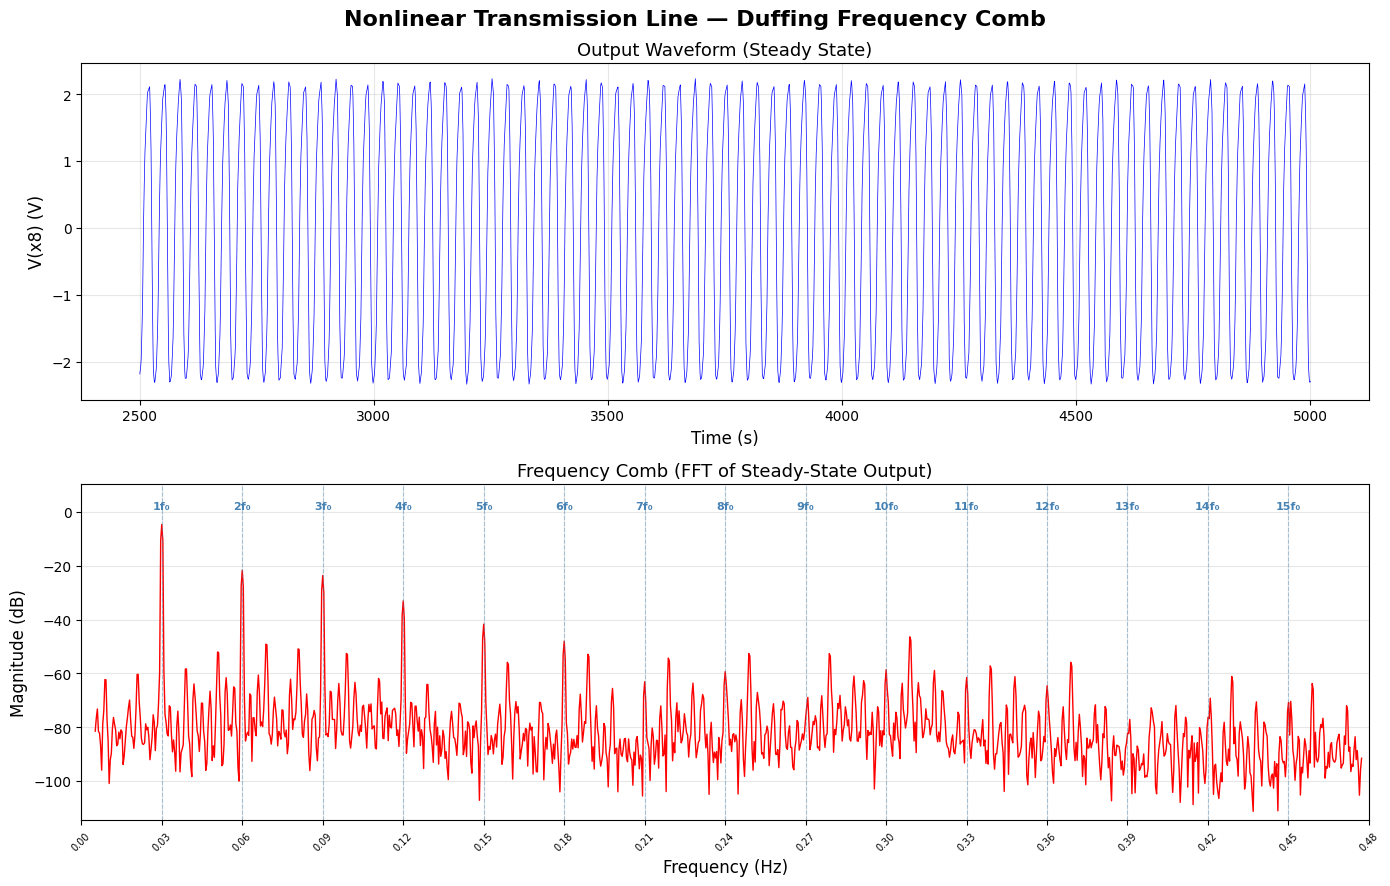

In [56]:

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(14, 9))
fig.suptitle('Nonlinear Transmission Line — Duffing Frequency Comb', fontsize=16, fontweight='bold')

# Time domain
ax1 = axes[0]
ax1.plot(t_ss, v_ss, 'b-', linewidth=0.5)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('V(x8) (V)', fontsize=12)
ax1.set_title('Output Waveform (Steady State)', fontsize=13)
ax1.grid(True, alpha=0.3)

# FFT
ax2 = axes[1]
f_cutoff = 1 / (np.pi * np.sqrt(1))  # ~0.318 Hz for L=1, C=1
f_max = min(f_cutoff * 1.5, freqs[-1])
freq_mask = (freqs > 0.005) & (freqs <= f_max)

ax2.plot(freqs[freq_mask], magnitude_dB[freq_mask], 'r-', linewidth=1.0)

# Mark comb lines
f_drive = 0.03
peak_dB = np.max(magnitude_dB[freq_mask])
for n in range(1, int(f_max / f_drive) + 1):
    f_line = n * f_drive
    if f_line <= f_max:
        ax2.axvline(x=f_line, color='steelblue', linewidth=0.8, linestyle='--', alpha=0.4)
        ax2.text(f_line, peak_dB + 5, f'{n}f\u2080', ha='center', va='bottom',
                 fontsize=8, color='steelblue', fontweight='bold')

ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude (dB)', fontsize=12)
ax2.set_title('Frequency Comb (FFT of Steady-State Output)', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(peak_dB - 110, peak_dB + 15)
ax2.set_xlim(0, f_max)

comb_ticks = np.arange(0, f_max + f_drive, f_drive)
ax2.set_xticks(comb_ticks)
ax2.set_xticklabels([f'{f:.2f}' for f in comb_ticks], fontsize=7, rotation=45)

plt.tight_layout()

plt.show()